### Dask Delayed Basic

In [2]:
from dask import delayed
import dask
import numpy as np
from dask.distributed import Client, LocalCluster

In [2]:
def my_square_function(x):
    return x**2

#create delayed version of above function
delayed_square_function = delayed(my_square_function)

#Use the delayed function
delayed_result = delayed_square_function(4)

print(delayed_result)

Delayed('my_square_function-5c0fbacd-3c3c-4578-995c-dcbe20a9d001')


In [21]:
%time
#To Run the calculation
real_result = delayed_result.compute() #Where the actual calculation happen

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.58 μs


In [ ]:
%%time
#Compare to non delayed version
result = my_square_function(4)

CPU times: user 0 ns, sys: 3 μs, total: 3 μs
Wall time: 4.77 μs


In [23]:
print(real_result)
print(result)

16
16


In [24]:
# Using Operation on delayed objects
delayed_result = delayed(my_square_function)(5)
# Math operation on delayed objects
final_delayed_result = delayed_result * 2

print(final_delayed_result)

Delayed('mul-9977714cfc266b6bc7c66b01167b62a0')


In [25]:
# Actual result

print(final_delayed_result.compute())

50


In [30]:
%%timeit -n 5 -r 10
# Using delayed (default is threaded scheduler, supposed to be not really parallel due to GIL)
# x_list = [30, 85, 14, 12, 27, 62, 89, 15, 78, 0]
x_list = range(1000)
sum_of_squares = 0

for x in x_list:
    # Square and add numbers
    sum_of_squares += delayed(my_square_function)(x)

result = sum_of_squares.compute()

482 ms ± 22.1 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [36]:
%%timeit -n 5 -r 10
# Non delayed version
# x_list = [30, 85, 14, 12, 27, 62, 89, 15, 78, 0]
x_list = range(1000)
sum_of_squares = 0

for x in x_list:
    # Square and add numbers
    sum_of_squares += my_square_function(x)

result2 = sum_of_squares

87.7 μs ± 29.2 μs per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [35]:
print(result)
print(result2)

332833500
332833500


In [37]:
# Inefficient, delayed_intermediate are computed twice
delayed_intermediate = delayed(my_square_function)(3)

# These 2 both use delayed_intermediate
delayed_result1 = delayed_intermediate - 5
delayed_result2 = delayed_intermediate + 3

# delayed_intermediate (3 squared) will be computed twice
print('delayed_result1:', delayed_result1.compute())
print('delayed_result2:', delayed_result2.compute())

delayed_result1: 4
delayed_result2: 12


In [38]:
# More efficient version:
import dask

comp_result1, comp_result2 = dask.compute(delayed_result1, delayed_result2)

print('comp_result1:', comp_result1)
print('comp_result2:', comp_result2)

comp_result1: 4
comp_result2: 12


### Task Graph & Scheduling Method

In [54]:
import numpy as np
from dask.distributed import Client, LocalCluster

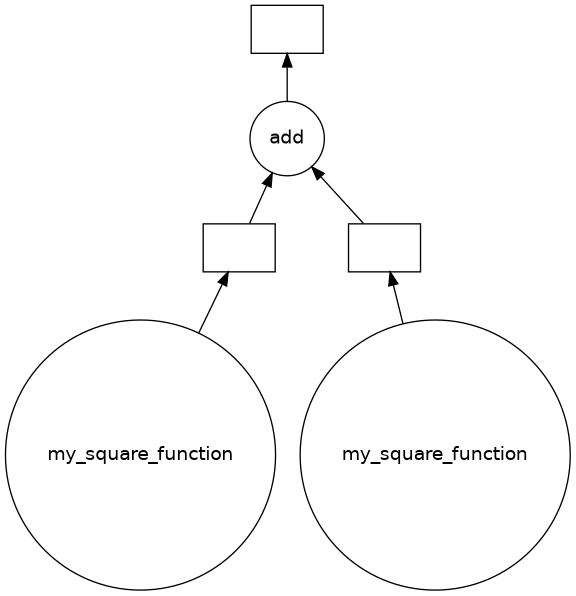

In [39]:
# Visualizing the task graph

# Create 2 delayed objects
delayed_num1 = delayed(my_square_function)(3)
delayed_num2 = delayed(my_square_function)(4)

# Add them
result = delayed_num1 + delayed_num2

#Plot task graph
result.visualize()

In [41]:
print(result) # Delayed object, not computed yet
print(result.compute()) # Compute the result

Delayed('add-f0713e78f91b5cda1221edda7c95b60b')
25


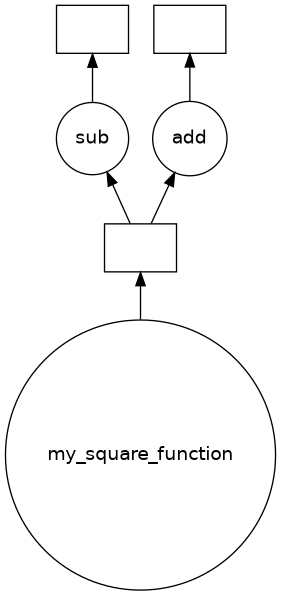

In [43]:
dask.visualize(delayed_result1, delayed_result2)
# dask.visualize(delayed_num1, delayed_num2)

In [73]:
# array1 = range(1000)
# array2 = range(1000, 2000)

# array1 = range(1000000)
# array2 = range(1000000, 2000000)

array1 = range(10000000)
array2 = range(10000000, 20000000)

In [51]:
# Multi processing/ parallel processing: Multi python instances, each with their own RAM
# Multi Threading: Single python instance, shared RAM, but limited by GIL (Global Interpreter Lock)

In [ ]:
# Placeholder, run on section below after creating the client
# Run sum on two arrays
sum1 = delayed(np.sum)(array1)
sum2 = delayed(np.sum)(array2)

#Compute using processes
dask.compute(sum1, sum2)

#Slow using parallel processing, because array1 and array2 are copied to each process and returned to main python session
#Faster on multithreading, because array1 and array2 are shared in the same RAM space

(np.int64(499500), np.int64(1499500))

In [74]:
# Create multiprocessing client & Cluster
client = Client(
    processes=True,
    n_workers=8,
    threads_per_worker=1
)

print(client)
print(client.dashboard_link)

/home/maludinrady/dask-env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38903 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:45557' processes=8 threads=8, memory=31.34 GiB>
http://127.0.0.1:38903/status


In [75]:
%%timeit -n 5 -r 10
# MULTI PROCESSING
# Run sum on two arrays
sum1 = delayed(np.sum)(array1)
sum2 = delayed(np.sum)(array2)

#Compute using processes
dask.compute(sum1, sum2)

#Slow using parallel processing, because array1 and array2 are copied to each process and returned to main python session
#Faster on multithreading, because array1 and array2 are shared in the same RAM space

528 ms ± 11 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [76]:
client.close()

In [77]:
# Create multiprocessing client & Cluster
client = Client(
    processes=False,
    n_workers=1,
    threads_per_worker=8
)

print(client)
print(client.dashboard_link)

<Client: 'inproc://172.30.53.158/1241/19' processes=1 threads=8, memory=31.34 GiB>
http://172.30.53.158:45559/status


/home/maludinrady/dask-env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45559 instead
  warnings.warn(


In [78]:
%%timeit -n 5 -r 10
# MULTI-THREADING
# Run sum on two arrays
sum1 = delayed(np.sum)(array1)
sum2 = delayed(np.sum)(array2)

#Compute using processes
dask.compute(sum1, sum2)

#Slow using parallel processing, because array1 and array2 are copied to each process and returned to main python session
#Faster on multithreading, because array1 and array2 are shared in the same RAM space

1.03 s ± 62.6 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [79]:
client.close()

In [80]:
%%timeit -n 5 -r 10
# NOT PARALLEL
# Run sum on two arrays
sum1 = np.sum(array1)
sum2 = np.sum(array2)

#Slow using parallel processing, because array1 and array2 are copied to each process and returned to main python session
#Faster on multithreading, because array1 and array2 are shared in the same RAM space

1.03 s ± 58.5 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [89]:
# RESULTS

# Runtime 2*1000 arrays:
# Multiprocessing: 15.8 ms 
# Multi-threading: 10.8 ms
# Not parallel: 152 μs

# Runtime 2*1Mio arrays:
# Multiprocessing: 64 ms 
# Multi-threading: 118 ms
# Not parallel: 102 ms

# Runtime 2*10Mio arrays:
# Multiprocessing: 528 ms 
# Multi-threading: 1.03 s
# Not parallel: 1.03 s
# Multiprocessing(cluster-client): 539 ms
# Multi-threading(cluster-client): 1.06 s

#Multi Processing benefit is observed on larger arrays, but not on smaller arrays


In [84]:
# Using another method to create a Dask cluster and client
# MULTIPROCESSING
# Step 1: Create Cluster
cluster = LocalCluster(
    processes=True,
    n_workers=8,
    threads_per_worker=1
)

# Step 2: Connect Client
client = Client(cluster)

/home/maludinrady/dask-env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35681 instead
  warnings.warn(


In [85]:
%%timeit -n 5 -r 10
# Step 3: Do some Dask computation
# Run sum on two arrays
sum1 = delayed(np.sum)(array1)
sum2 = delayed(np.sum)(array2)

#Compute using processes
dask.compute(sum1, sum2)

539 ms ± 12.4 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [86]:
# Step 4: Close resources
client.close()
cluster.close()

In [87]:
# Using another method to create a Dask cluster and client
# MULTIPROCESSING
# Step 1: Create Cluster
cluster = LocalCluster(
    processes=False,
    n_workers=1,
    threads_per_worker=8
)

# Step 2: Connect Client
client = Client(cluster)


/home/maludinrady/dask-env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38215 instead
  warnings.warn(


In [88]:
%%timeit -n 5 -r 10
# Step 3: Do some Dask computation
# Run sum on two arrays
sum1 = delayed(np.sum)(array1)
sum2 = delayed(np.sum)(array2)

#Compute using thread
dask.compute(sum1, sum2)

1.06 s ± 45.8 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [90]:
# Step 4: Close resources
client.close()
cluster.close()

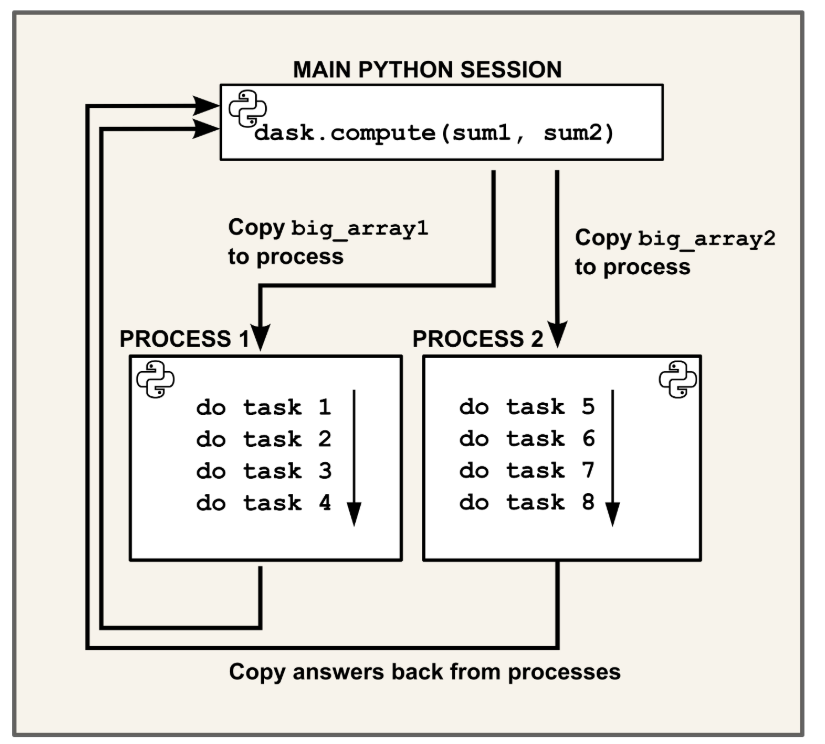

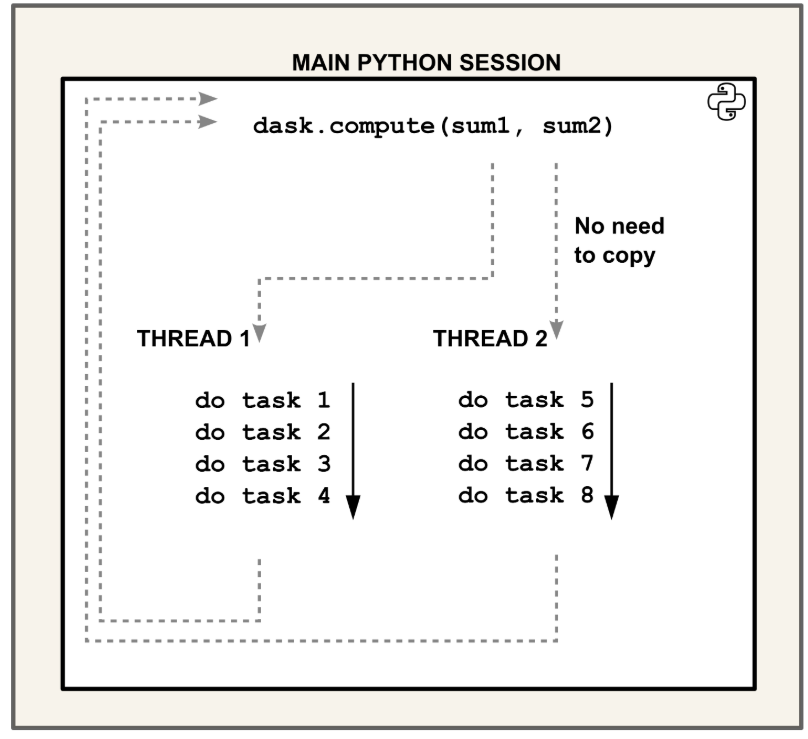

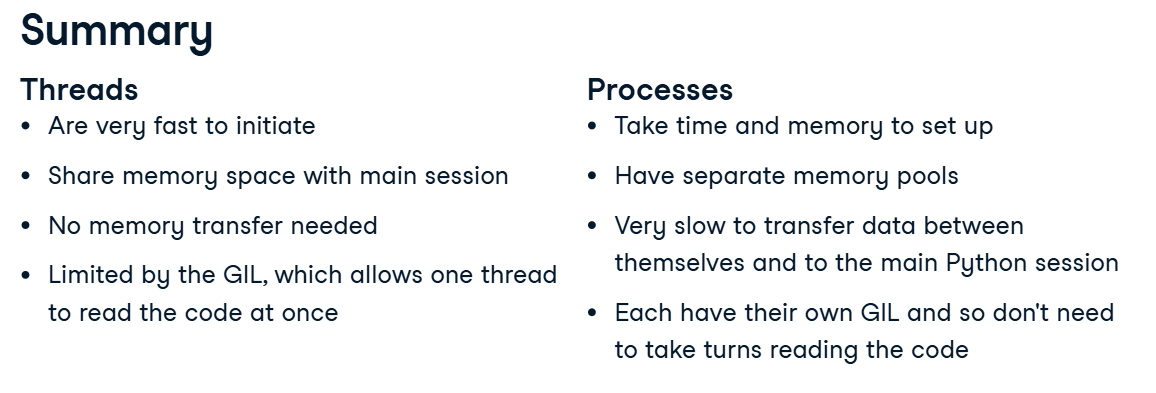

In [91]:
# GIL Simulation - PLACEHOLDER
# GIL --> Only one thread can execute Python bytecode at a time
# This means that even if you have multiple threads, only one can run Python code at a time.
# This is why multi-threading in Python doesn't provide true parallelism for CPU-bound tasks
def sum_to_n(n):
    # Sum number from 0 tp n
    total = 0
    for i in range (n+1):
        total +=i
    return total

# Multi-threading won't help here
# Parallel processing will
# sum1 = delayed(sum_to_n)(1000)
# sum2 = delayed(sum_to_n)(1000)


In [100]:
%%timeit -n 5 -r 10
#NOT PARALLEL
sum1 = sum_to_n(100000000)

2.79 s ± 56.4 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [101]:
# Create multiprocessing client & Cluster
client = Client(
    processes=True,
    n_workers=8,
    threads_per_worker=1
)

print(client)
print(client.dashboard_link)

/home/maludinrady/dask-env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46593 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:41551' processes=8 threads=8, memory=31.34 GiB>
http://127.0.0.1:46593/status


In [102]:
%%timeit -n 5 -r 10
#MULTIPROCESSING
sum1 = delayed(sum_to_n)(100000000)
sum1.compute()

2.69 s ± 74.8 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [103]:
client.close()

In [104]:
# Create MULTITHREAD client & Cluster
client = Client(
    processes=False,
    n_workers=1,
    threads_per_worker=8
)

print(client)
print(client.dashboard_link)

<Client: 'inproc://172.30.53.158/1241/486' processes=1 threads=8, memory=31.34 GiB>
http://172.30.53.158:46717/status


/home/maludinrady/dask-env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46717 instead
  warnings.warn(


In [105]:
%%timeit -n 5 -r 10
#MULTITHREADING
sum2 = delayed(sum_to_n)(100000000)
sum2.compute()

2.89 s ± 36.1 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [99]:
client.close()

### DELAYED PIPELINES

In [4]:
import pandas as pd
import glob

folder_path = "/home/maludinrady/code/6_dask-datacamp/Data/spotify"
files = glob.glob(f"{folder_path}/*.csv")

maximums = []
for file in files:
    # Load each file
    df = pd.read_csv(file)
    # Find maximum track length in each file
    max_length = df['duration_ms'].max()
    # Store this maximum
    maximums.append(max_length)

# Find the maximum of all the maximum lengths
absolute_maximum = max(maximums)
absolute_maximum



np.int64(5403500)

In [5]:
%%timeit -n 5 -r 10
# NO PARALLEL
maximums = []

for file in files:
    # Load each file
    df = pd.read_csv(file)
    # Find maximum track length in each file
    max_length = df['duration_ms'].max()
    # Store this maximum
    maximums.append(max_length)

# Find the maximum of all the maximum lengths
absolute_maximum = max(maximums)

276 ms ± 7.56 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [16]:
# Create multiprocessing client & Cluster
client = Client(
    processes=True,
    n_workers=8,
    threads_per_worker=1
)

print(client)
print(client.dashboard_link)

<Client: 'tcp://127.0.0.1:37471' processes=8 threads=8, memory=31.34 GiB>
http://127.0.0.1:8787/status


In [17]:
%%timeit -n 5 -r 10
# Multiprocessing
maximums = []

for file in files:
    # Load each file
    df = delayed(pd.read_csv)(file)
    # Find maximum track length in each file
    max_length = df['duration_ms'].max()
    # Store this maximum
    maximums.append(max_length)

# Find the maximum of all the maximum lengths
absolute_maximum = delayed(max)(maximums)
absolute_maximum.compute()

126 ms ± 14.3 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [18]:
client.close()

In [9]:
# Create MULTITHREAD client & Cluster
client = Client(
    processes=False,
    n_workers=1,
    threads_per_worker=8
)

print(client)
print(client.dashboard_link)

<Client: 'inproc://172.30.53.158/80564/1' processes=1 threads=8, memory=31.34 GiB>
http://172.30.53.158:8787/status


In [13]:
%%timeit -n 5 -r 10
# MULTITHREADING
maximums = []

for file in files:
    # Load each file
    df = delayed(pd.read_csv)(file)
    # Find maximum track length in each file
    max_length = df['duration_ms'].max()
    # Store this maximum
    maximums.append(max_length)

# Find the maximum of all the maximum lengths
absolute_maximum = delayed(max)(maximums)
absolute_maximum.compute()

325 ms ± 3.87 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [14]:
client.close()

In [15]:
absolute_maximum

Delayed('max-1aeb9ae2-95fa-4e11-8c76-a9ba47413660')

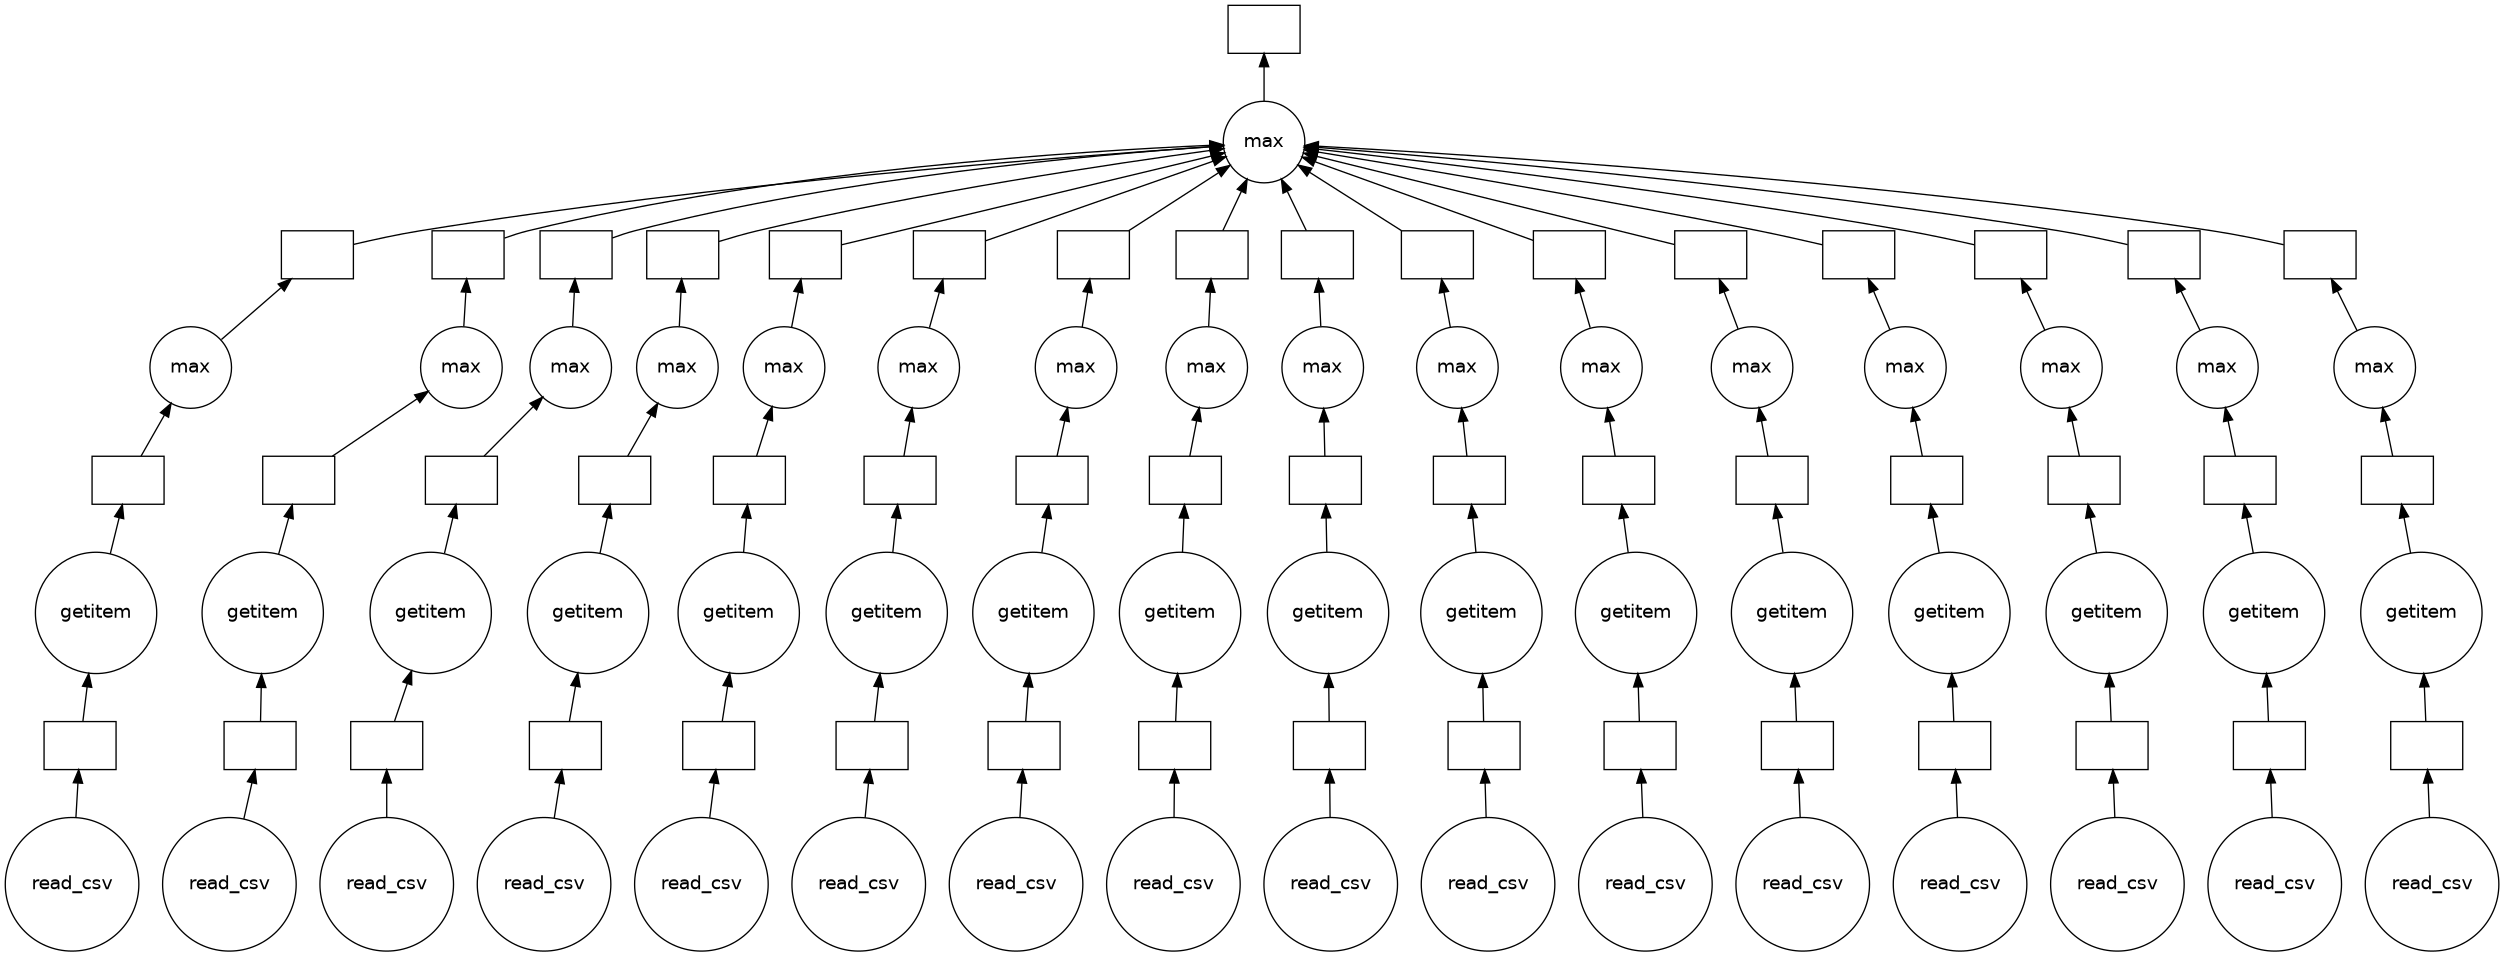

In [12]:
absolute_maximum.visualize()

In [ ]:
# Lazy Evaluate Integer (Multiple Threads - Default)
n_songs_in_c, n_songs = 0, 0 

for file in files:
    # Load in the data
    df = delayed(pd.read_csv)(file)
    
    # Add to running totals
    n_songs_in_c += (df['key'] == 'C').sum()
    n_songs += df.shape[0]

# Efficiently compute total_n_songs_in_c and total_n_songs
total_n_songs_in_c, total_n_songs = dask.compute(n_songs_in_c, n_songs)

fraction_c = total_n_songs_in_c / total_n_songs
print(total_n_songs, fraction_c)

161738 0.11824679419802396


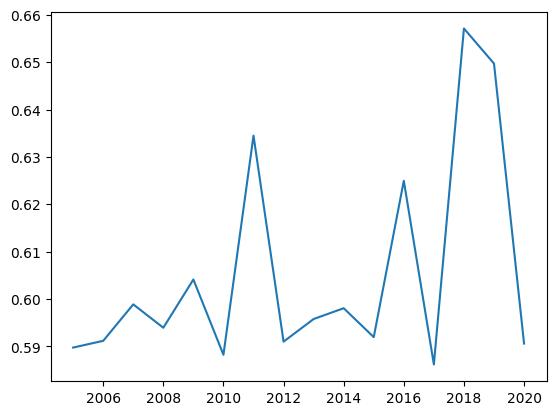

In [24]:
import matplotlib.pyplot as plt

# Lazy Evaluate: Array
years = range(2005, 2021)
danceabilities = []

for file in files:
	# Lazily load in the data
    df = delayed(pd.read_csv)(file)
    # Calculate the average danceability in the file of songs
    mean_danceability = df['danceability'].mean()
    danceabilities.append(mean_danceability)

# Compute all the mean danceabilities
danceability_list = dask.compute(danceabilities)[0]
# Plot the results
plt.plot(years, danceability_list)
plt.show()

In [26]:
# Lazy Evaluation, Array lalu diconcat

top_songs = []

def top_10_most_popular(df):
  return df.nlargest(n=10, columns='popularity')

for file in files:
    df = delayed(pd.read_csv)(file)
    # Find the top 10 most popular songs in this file
    df_top_10 = top_10_most_popular(df)
    top_songs.append(df_top_10)

# Compute the list of top 10s
top_songs_list = dask.compute(top_songs)[0]

# Concatenate them and find the best of the best
top_songs_df = pd.concat(top_songs_list)
df_all_time_top_10 = top_10_most_popular(top_songs_df)
print(df_all_time_top_10)

                           id                    name  popularity  \
2257   5QO79kh1waicV47BqGRL3g         Save Your Tears          97   
11698  6tDDoYIxWvMLTdKpjFkc1B               telepatía          97   
2280   0VjIjW4GlUZAMYd2vXMi3b         Blinding Lights          96   
7835   6f3Slt0GbA2bPZlz0aIFXN            The Business          95   
2489   3FAJ6O0NOHQV8Mc5Ri6ENp  Heartbreak Anniversary          94   
10238  27OeeYzk6klgBh83TSvGMA             WITHOUT YOU          94   
11850  1xK1Gg9SxG8fy2Ya373oqb                 Bandido          94   
9090   60ynsPSSKe6O3sfwRnIBRf                 Streets          94   
11238  2XIc1pqjXV3Cr2BQUGNBck      LA NOCHE DE ANOCHE          93   
13368  3YJJjQPAbDT7mGpX3WtQ9A               Good Days          93   

       duration_ms  explicit                   artists release_date  \
2257        215627         1            ['The Weeknd']   2020-03-20   
11698       160191         0            ['Kali Uchis']   2020-12-04   
2280        200040         

### Below section is about Dask Array, Dataframe, and Bags. Not finished yet 

In [11]:
%time 
import numpy as np
x = np.ones((4000, 6000))

print(x.sum())

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.34 μs
24000000.0


In [12]:
x

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], shape=(4000, 6000))

In [13]:
%time
import dask.array as da
x = da.ones((4000, 6000), chunks=(1000, 2000))

z = x.sum().compute()
print(z)


CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.86 μs
24000000.0


In [14]:
x

dask.array<ones_like, shape=(4000, 6000), dtype=float64, chunksize=(1000, 2000), chunktype=numpy.ndarray>

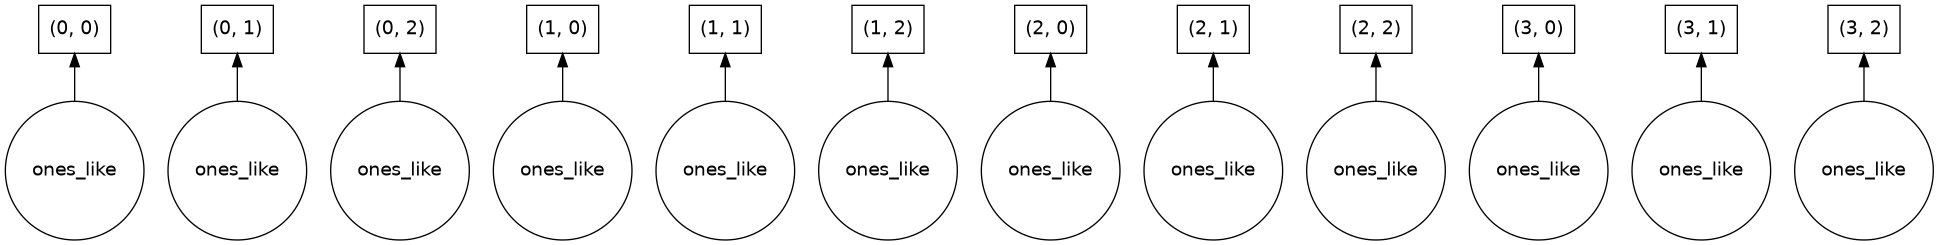

In [15]:
x.visualize()

In [ ]:
# GA DIRUN
# Import dask dataframe as dd
import dask.dataframe as dd

# Load in the DataFrame
df  = dd.read_csv('data/spotify/*.csv', blocksize = "1MB")

# Convert the release_date column from string to datetime
df['release_date']=dd.to_datetime(df['release_date'])

# Show 5 rows of the DataFrame
print(df.head())


In [ ]:
# GA DIRUN
# Read the spotify_parquet folder
df = dd.read_parquet("data/spotify_parquet")

# Find the 10 most popular songs
top_10_songs = df.nlargest(10, 'popularity')

# Convert the delayed result to a pandas DataFrame
top_10_songs_df = top_10_songs.compute()

print(top_10_songs_df)

In [ ]:
# GA DIRUN
# Extract the months from the release_date column using its datetime accessor 
months = df['release_date'].dt.month

# Group the danceabilities by month
monthly_groupby = df['danceability'].groupby(months)

# Find the mean danceability by month
monthly_danceability = monthly_groupby.mean()

# Compute the result
monthly_danceability_result = monthly_danceability.compute()

monthly_danceability_result.plot()
plt.show()

In [ ]:
# GA DIRUN - XARRAY
# Open the ERA5 dataset
ds = xr.open_zarr("data/era_eu.zarr")

# Select the zeroth time in the DataSet
ds_sel = ds.isel(time=0)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 3))

# Plot the zeroth temperature field on ax1
ds_sel['temp'].plot(ax=ax1)

# Plot the zeroth precipitation field on ax2
ds_sel['precip'].plot(ax=ax2)
plt.show()

In [ ]:
from dask.distributed import LocalCluster

cluster = LocalCluster(
    n_workers=4,  # Number of workers
    threads_per_worker=2,  # Number of threads per worker
    processes=True,  # Use processes instead of threads)
)
print(cluster)
print(cluster.dashboard_link)

LocalCluster(9deb670a, 'tcp://127.0.0.1:39423', workers=4, threads=8, memory=31.34 GiB)
http://127.0.0.1:8787/status


In [20]:
cluster.close()

In [21]:
# Yang ini jatuhnya tiap thread ada 2 thread (Lebih besar resourcenya)
cluster = LocalCluster(
    n_workers=4,  
    threads_per_worker=2, 
    processes=False
)
print(cluster)
print(cluster.dashboard_link)

LocalCluster(2c890bc0, 'inproc://172.30.53.158/1359/31', workers=4, threads=8, memory=31.34 GiB)
http://172.30.53.158:38957/status


/home/maludinrady/dask-env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38957 instead
  warnings.warn(


In [22]:
cluster.close()

In [23]:
cluster = LocalCluster(
    processes=True
)
print(cluster)
print(cluster.dashboard_link)

/home/maludinrady/dask-env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34697 instead
  warnings.warn(


LocalCluster(fbc7cfda, 'tcp://127.0.0.1:45031', workers=4, threads=12, memory=31.34 GiB)
http://127.0.0.1:34697/status


In [24]:
cluster.close()

In [25]:
cluster = LocalCluster(
    processes=False
)
print(cluster)
print(cluster.dashboard_link)

LocalCluster(68d00a28, 'inproc://172.30.53.158/1359/46', workers=1, threads=12, memory=31.34 GiB)
http://172.30.53.158:44287/status


/home/maludinrady/dask-env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44287 instead
  warnings.warn(


In [26]:
cluster.close()

In [ ]:
# GA DIRUN
# Dask ML Wrapper (1 loop)
# Import the SGDRegressor and the Incremental wrapper
from sklearn.linear_model import SGDRegressor
from dask_ml.wrappers import Incremental

# Create a SGDRegressor model
model = SGDRegressor()

# Wrap the model so that it works with Dask
dask_model = Incremental(model, scoring='neg_mean_squared_error')

# Fit the wrapped model
dask_model.fit(dask_X, dask_y)